# EDA and Visualization Final Project: Data Prep and Analysis
## Zachary Barnes and Bing Wang

##### Housekeeping

In [1]:
# Load Python libraries
import os
import numpy as np
import pandas as pd

# Run R code adjacent to Python code
%load_ext rpy2.ipython

# Load ggplot R library
%R library(ggplot2)
%R library(scales)

# Avoid kernal death
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Read in and organize data from TIMS (Collisions and Victims)

#### Collisions data

In [2]:
c = pd.read_csv("Collisions.csv")

# Keep only relevant columns
c = c[['CASE_ID','COLLISION_DATE','COLLISION_TIME', 'LOCATION_TYPE', 
       'PEDESTRIAN_ACCIDENT', 'BICYCLE_ACCIDENT', 'MOTORCYCLE_ACCIDENT', 
       'TRUCK_ACCIDENT','POINT_X','POINT_Y']]

Make datetime variables

In [3]:
# Convert COLLISION_TIME to hour of day (use tlater to match speeds to collisions)
c['COLLISION_TIME'] = [int(i[:-2]) if len(i) > 2 else 0 for i in c['COLLISION_TIME'].astype(str).values]

# Make Collision_Date a DateTime object
c["COLLISION_DATE"] = pd.to_datetime(c.COLLISION_DATE)

# Add quarter column (use later in match speeds to collisions)
c['QUARTER'] = c['COLLISION_DATE'].map(pd.to_datetime).dt.quarter

c.sample(5)

,CASE_ID,COLLISION_DATE,COLLISION_TIME,LOCATION_TYPE,PEDESTRIAN_ACCIDENT,BICYCLE_ACCIDENT,MOTORCYCLE_ACCIDENT,TRUCK_ACCIDENT,POINT_X,POINT_Y,QUARTER
2828,8594635,2018-03-03,15,NaN,Y,NaN,NaN,NaN,-122.473657,37.759970,1
1987,8656319,2018-06-05,18,NaN,NaN,NaN,NaN,NaN,-122.503460,37.771680,2
2079,8651586,2018-08-03,18,NaN,NaN,NaN,NaN,NaN,-122.388010,37.742730,3
3453,90739074,2018-05-21,10,NaN,NaN,NaN,NaN,NaN,-122.406237,37.734497,2
2590,8603116,2018-04-09,15,NaN,NaN,NaN,NaN,NaN,-122.422596,37.775047,2


Recode some variables

In [4]:
# for dummies: recode Y as 1, blank as 0
def Yfor1(s):
    s = s.replace("Y", 1)
    s = s.fillna(0)
    return s

In [5]:
c["PEDESTRIAN_ACCIDENT"] = Yfor1(c.PEDESTRIAN_ACCIDENT)
c["BICYCLE_ACCIDENT"] = Yfor1(c.BICYCLE_ACCIDENT)
c["MOTORCYCLE_ACCIDENT"] = Yfor1(c.MOTORCYCLE_ACCIDENT)
c["TRUCK_ACCIDENT"] = Yfor1(c.TRUCK_ACCIDENT)

In [6]:
c.sample(5)

,CASE_ID,COLLISION_DATE,COLLISION_TIME,LOCATION_TYPE,PEDESTRIAN_ACCIDENT,BICYCLE_ACCIDENT,MOTORCYCLE_ACCIDENT,TRUCK_ACCIDENT,POINT_X,POINT_Y,QUARTER
546,8764292,2018-11-04,12,NaN,0.0,0.0,0.0,0.0,-122.407460,37.783510,4
3265,8553163,2018-01-31,22,NaN,0.0,0.0,0.0,0.0,-122.422180,37.768150,1
3343,8552849,2018-01-29,13,NaN,0.0,1.0,0.0,0.0,-122.419109,37.782722,1
2770,8597206,2018-03-30,21,NaN,0.0,0.0,1.0,0.0,-122.409692,37.783340,1
18,90731605,2018-05-13,11,NaN,0.0,0.0,0.0,0.0,-122.368151,37.807152,2


#### Victims data

In [7]:
v = pd.read_csv('Victims.csv')

# Keep only relevant columns
v = v[['CASE_ID','VICTIM_DEGREE_OF_INJURY','VICTIM_AGE']]

Our main variable of interest is victim degree of injury from this Victims dataset, which is a categorial variable. We are only interested in VICTIM_DEGREE_OF_INJURY = 1 or 2, for fatalities and severe injuries, respectively. 

We will filter for observations with just those two levels of injury, and create a categorical variable, VDOI, for ease of graphing.

In [8]:
# Keep only fatalities and severe injuries (Victim_Degree_of_Injury = 1 or 2)
v = v.loc[v.VICTIM_DEGREE_OF_INJURY.isin([1, 2])]

# Make VDOI, a categorical variable version of VICTIM_DEGREE_OF_INJURY
v.loc[v.VICTIM_DEGREE_OF_INJURY == 1, "VDOI"] = "Fatalities"
v.loc[v.VICTIM_DEGREE_OF_INJURY == 2, "VDOI"] = "Severe injuries"

v.head()

,CASE_ID,VICTIM_DEGREE_OF_INJURY,VICTIM_AGE,VDOI
13,8804193,2,998,Severe injuries
16,8804185,2,32,Severe injuries
23,8796720,2,30,Severe injuries
25,8796660,2,19,Severe injuries
31,8796604,2,39,Severe injuries


#### Merge (Join) Collisions and Victims databases on Case ID, for a full accident report dataset

In [9]:
cv = pd.merge(c, v, how='left', on='CASE_ID')

Change NaNs to "nan" for string columns before moving to R environment

In [10]:
# Paul's Function to remove NaNs from columns
def fixDFcolsForR(myDF):
    for i in range(myDF.shape[1]): # for each col
        if myDF.iloc[:, i].dtype == 'O': # check if col is type object
            myDF.iloc[:, i] = myDF.iloc[:, i].astype(str) # if yes set type to string
    return myDF

In [11]:
cv = fixDFcolsForR(cv)
cv.sample(5)

,CASE_ID,COLLISION_DATE,COLLISION_TIME,LOCATION_TYPE,PEDESTRIAN_ACCIDENT,BICYCLE_ACCIDENT,MOTORCYCLE_ACCIDENT,TRUCK_ACCIDENT,POINT_X,POINT_Y,QUARTER,VICTIM_DEGREE_OF_INJURY,VICTIM_AGE,VDOI
1885,8667430,2018-06-01,10,nan,0.0,0.0,0.0,0.0,-122.474267,37.732142,2,NaN,NaN,nan
2158,8640380,2018-04-17,7,nan,0.0,0.0,0.0,0.0,-122.400750,37.766200,2,NaN,NaN,nan
1937,8661516,2018-06-27,11,nan,0.0,0.0,0.0,1.0,-122.439300,37.782430,2,NaN,NaN,nan
3306,8553123,2018-01-24,13,nan,0.0,0.0,1.0,0.0,-122.436400,37.723800,1,NaN,NaN,nan
1589,8693185,2018-08-04,0,nan,1.0,0.0,0.0,0.0,-122.414390,37.755720,3,NaN,NaN,nan


# Read in, organize, and join Speeds data from Uber Movements to Collisions-Victims dataset 

We have a dataset of speeds from Uber Movements, which can tell us the average speed traveled by cars on a certain street segment (down to the quarter of year and hour of day). These street segments are each attached to an Open Street Maps (OSM) ID. 

In our Collisions-Victims dataset, we have latitudes and longitudes. Latitudes and longitudes can be converted/matched to an OSM ID. 

We will use the Nominatim API to convert the lats and longs in our Collisions-Victims dataset to OSM IDs, in order to join the Collision-Victims dataset to the Speeds dataset.

#### Use Nominatim API to convert latitudes and longitudes of accidents in Collisions-Victims dataset to OSM ID

This function below makes calls to the Nominatim API to return an OSM ID for each lat/lon input.

In [12]:
import requests
import json

def osmid(lat,lon):
    URL = 'https://nominatim.openstreetmap.org/reverse?format=json&lat=%s&lon=%s'
    r = requests.get(URL % (lat,lon))
    data = json.loads(r.text)
    return data['osm_id']

The code snippet below creates osm.csv, a list of OSM IDS and their latitudes and longitudes. We will use this to attach OSM IDs to our Collisions-Victims dataset.

NOTE: This code has been commented out due to the long run time. We ran this code once and output the results to osm.csv, which we later read in for cleaning and analysis.

In [13]:
# import time
# lat_long = cv[['POINT_Y','POINT_X','VICTIM_DEGREE_OF_INJURY']]
# osm_id = list()
# for i,row in lat_long.iterrows():
#     if (np.isnan(row['POINT_Y']) or np.isnan(row['POINT_X'])) or np.isnan(row['VICTIM_DEGREE_OF_INJURY']):
#         osm_id.append('NONE')
#         continue
#     else:
#         time.sleep(2)
#         osm_id.append(osmid(row['POINT_Y'],row['POINT_X']))
# osm_series = pd.Series(osm_id)
# osm_series.to_csv('osm.csv')

#### Add OSM_ID column to Collisions-Victims dataset

In [14]:
# Since we have saved OSM ID data already, read in as csv
osm = pd.read_csv('osm.csv',header=None)

osm.columns = ['index','OSM_ID']
cv['OSM_ID'] = osm['OSM_ID']

#### Download, munge, and join Uber Speeds dataset to Collisions-Victims dataset

Using the Uber Movement data toolkit (a command-line tool made by Uber), we downloaded the dataset with the following line in the command line (currently commented out due to long runtime):

In [15]:
#! mdt speeds-transform stats san_francisco 2018-01-01 2018-12-31 > avgspeeds.csv

The line above pulls average speeds by street segment, quarter of the year, and hour of day in San Francisco for the year 2018.

We then read in and processed the raw Uber Movements dataset, avgspeeds.csv, by filtering it down to just the speeds observations that have a match among the accidents in the Collisions-Victims dataset. Specifically, we are matching a speed to an accident by the same OSM ID, quarter of year, and hour of day.

NOTE: This part of the code has been commented out due to long runtime. We outputted results to speed.csv, which we read in later for cleaning and analysis.

In [16]:
# avgspeeds = pd.read_csv('avgspeeds.csv')
# avgspeeds.head()

In [17]:
# speeds = list()
# for i, row in cvsmall.iterrows():
#     speed = avgspeeds.loc[(avgspeeds['osm_way_id'] == row['OSM_ID']) & 
#               (avgspeeds['quarter'] == row['QUARTER']) & 
#               (avgspeeds['hour_of_day'] == row['COLLISION_TIME'])]['speed_mph_mean']
#     if speed.values.size > 0:
#          speeds.append(speed.values[0])
        
#     else:
#         speeds.append(0)
# speeds = pd.Series(speeds)
# speeds.to_csv('speeds.csv')

Filter Collisions-Victims dataset down to observations with non-null quarters, collision time, and OSM ID, calling it csvsmall, before joining to speeds dataset

In [18]:
cvsmall = cv.loc[(~cv['QUARTER'].isna()) & (~cv['COLLISION_TIME'].isna()) & ~(cv['OSM_ID'] == 'NONE')]

The code below produces speeds.csv, a subset of averagespeeds.csv. It reduces the speeds observations down to ones that would match the Collisions-Victims dataset on OSD_ID, Quarter, and Collision_Time. If there is no match, set speed = 0.

Now, we join cvsmall (the reduced Collisions-Victims dataset) to the speeds dataset.

In [19]:
print(len(cvsmall))
cvsmall.head()

271


,CASE_ID,COLLISION_DATE,COLLISION_TIME,LOCATION_TYPE,PEDESTRIAN_ACCIDENT,BICYCLE_ACCIDENT,MOTORCYCLE_ACCIDENT,TRUCK_ACCIDENT,POINT_X,POINT_Y,QUARTER,VICTIM_DEGREE_OF_INJURY,VICTIM_AGE,VDOI,OSM_ID
251,8804185,2018-12-29,18,nan,0.0,0.0,1.0,0.0,-122.444840,37.746940,4,2.0,32.0,Severe injuries,148313526
254,8796720,2018-12-10,13,nan,0.0,0.0,1.0,0.0,-122.403498,37.805128,4,2.0,30.0,Severe injuries,2503369217
260,8796604,2018-12-28,18,nan,0.0,0.0,0.0,0.0,-122.462364,37.777302,4,2.0,39.0,Severe injuries,3802986672
261,8796085,2018-12-11,15,nan,0.0,0.0,1.0,0.0,-122.397722,37.779838,4,2.0,45.0,Severe injuries,467150002
266,8787863,2018-12-12,9,nan,1.0,0.0,0.0,0.0,-122.428359,37.774759,4,2.0,998.0,Severe injuries,27553863


Read in speeds.csv (the filtered down average speeds dataset)

In [20]:
speeds = pd.read_csv("speeds.csv",header=None)

Add speeds to Collisions-Speeds dataset as a column (speeds are in the same order as cvsmall's accidents already, as it was created by finding matches to the accidents' OSM IDs, quarter of year, and hour of day

In [21]:
cvsmall["SPEEDS"] = speeds[1].to_list()

# rename DataFrame to cvs to indicate Collision-Victim-Speeds dataset
cvs = cvsmall.loc[~(cvsmall['SPEEDS'] == 0)]  
cvs.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,CASE_ID,COLLISION_DATE,COLLISION_TIME,LOCATION_TYPE,PEDESTRIAN_ACCIDENT,BICYCLE_ACCIDENT,MOTORCYCLE_ACCIDENT,TRUCK_ACCIDENT,POINT_X,POINT_Y,QUARTER,VICTIM_DEGREE_OF_INJURY,VICTIM_AGE,VDOI,OSM_ID,SPEEDS
251,8804185,2018-12-29,18,nan,0.0,0.0,1.0,0.0,-122.444840,37.746940,4,2.0,32.0,Severe injuries,148313526,7.753
348,8777340,2018-12-01,22,nan,1.0,0.0,0.0,0.0,-122.424334,37.735083,4,2.0,998.0,Severe injuries,27396883,11.451
367,8777316,2018-12-02,22,nan,0.0,0.0,0.0,0.0,-122.426440,37.733670,4,2.0,29.0,Severe injuries,8914988,23.761
375,8777306,2018-12-27,13,nan,0.0,0.0,0.0,0.0,-122.379480,37.734140,4,2.0,23.0,Severe injuries,8916919,11.359
398,8777283,2018-12-28,16,nan,0.0,0.0,1.0,0.0,-122.424680,37.793730,4,2.0,29.0,Severe injuries,224384016,12.138


# Figures

In [22]:
%R -i cvs

## Fig 1: Map of accidents and accident severity

## Fig 2: Box plot showing spread of speeds by victim degree of injury (VDOI)

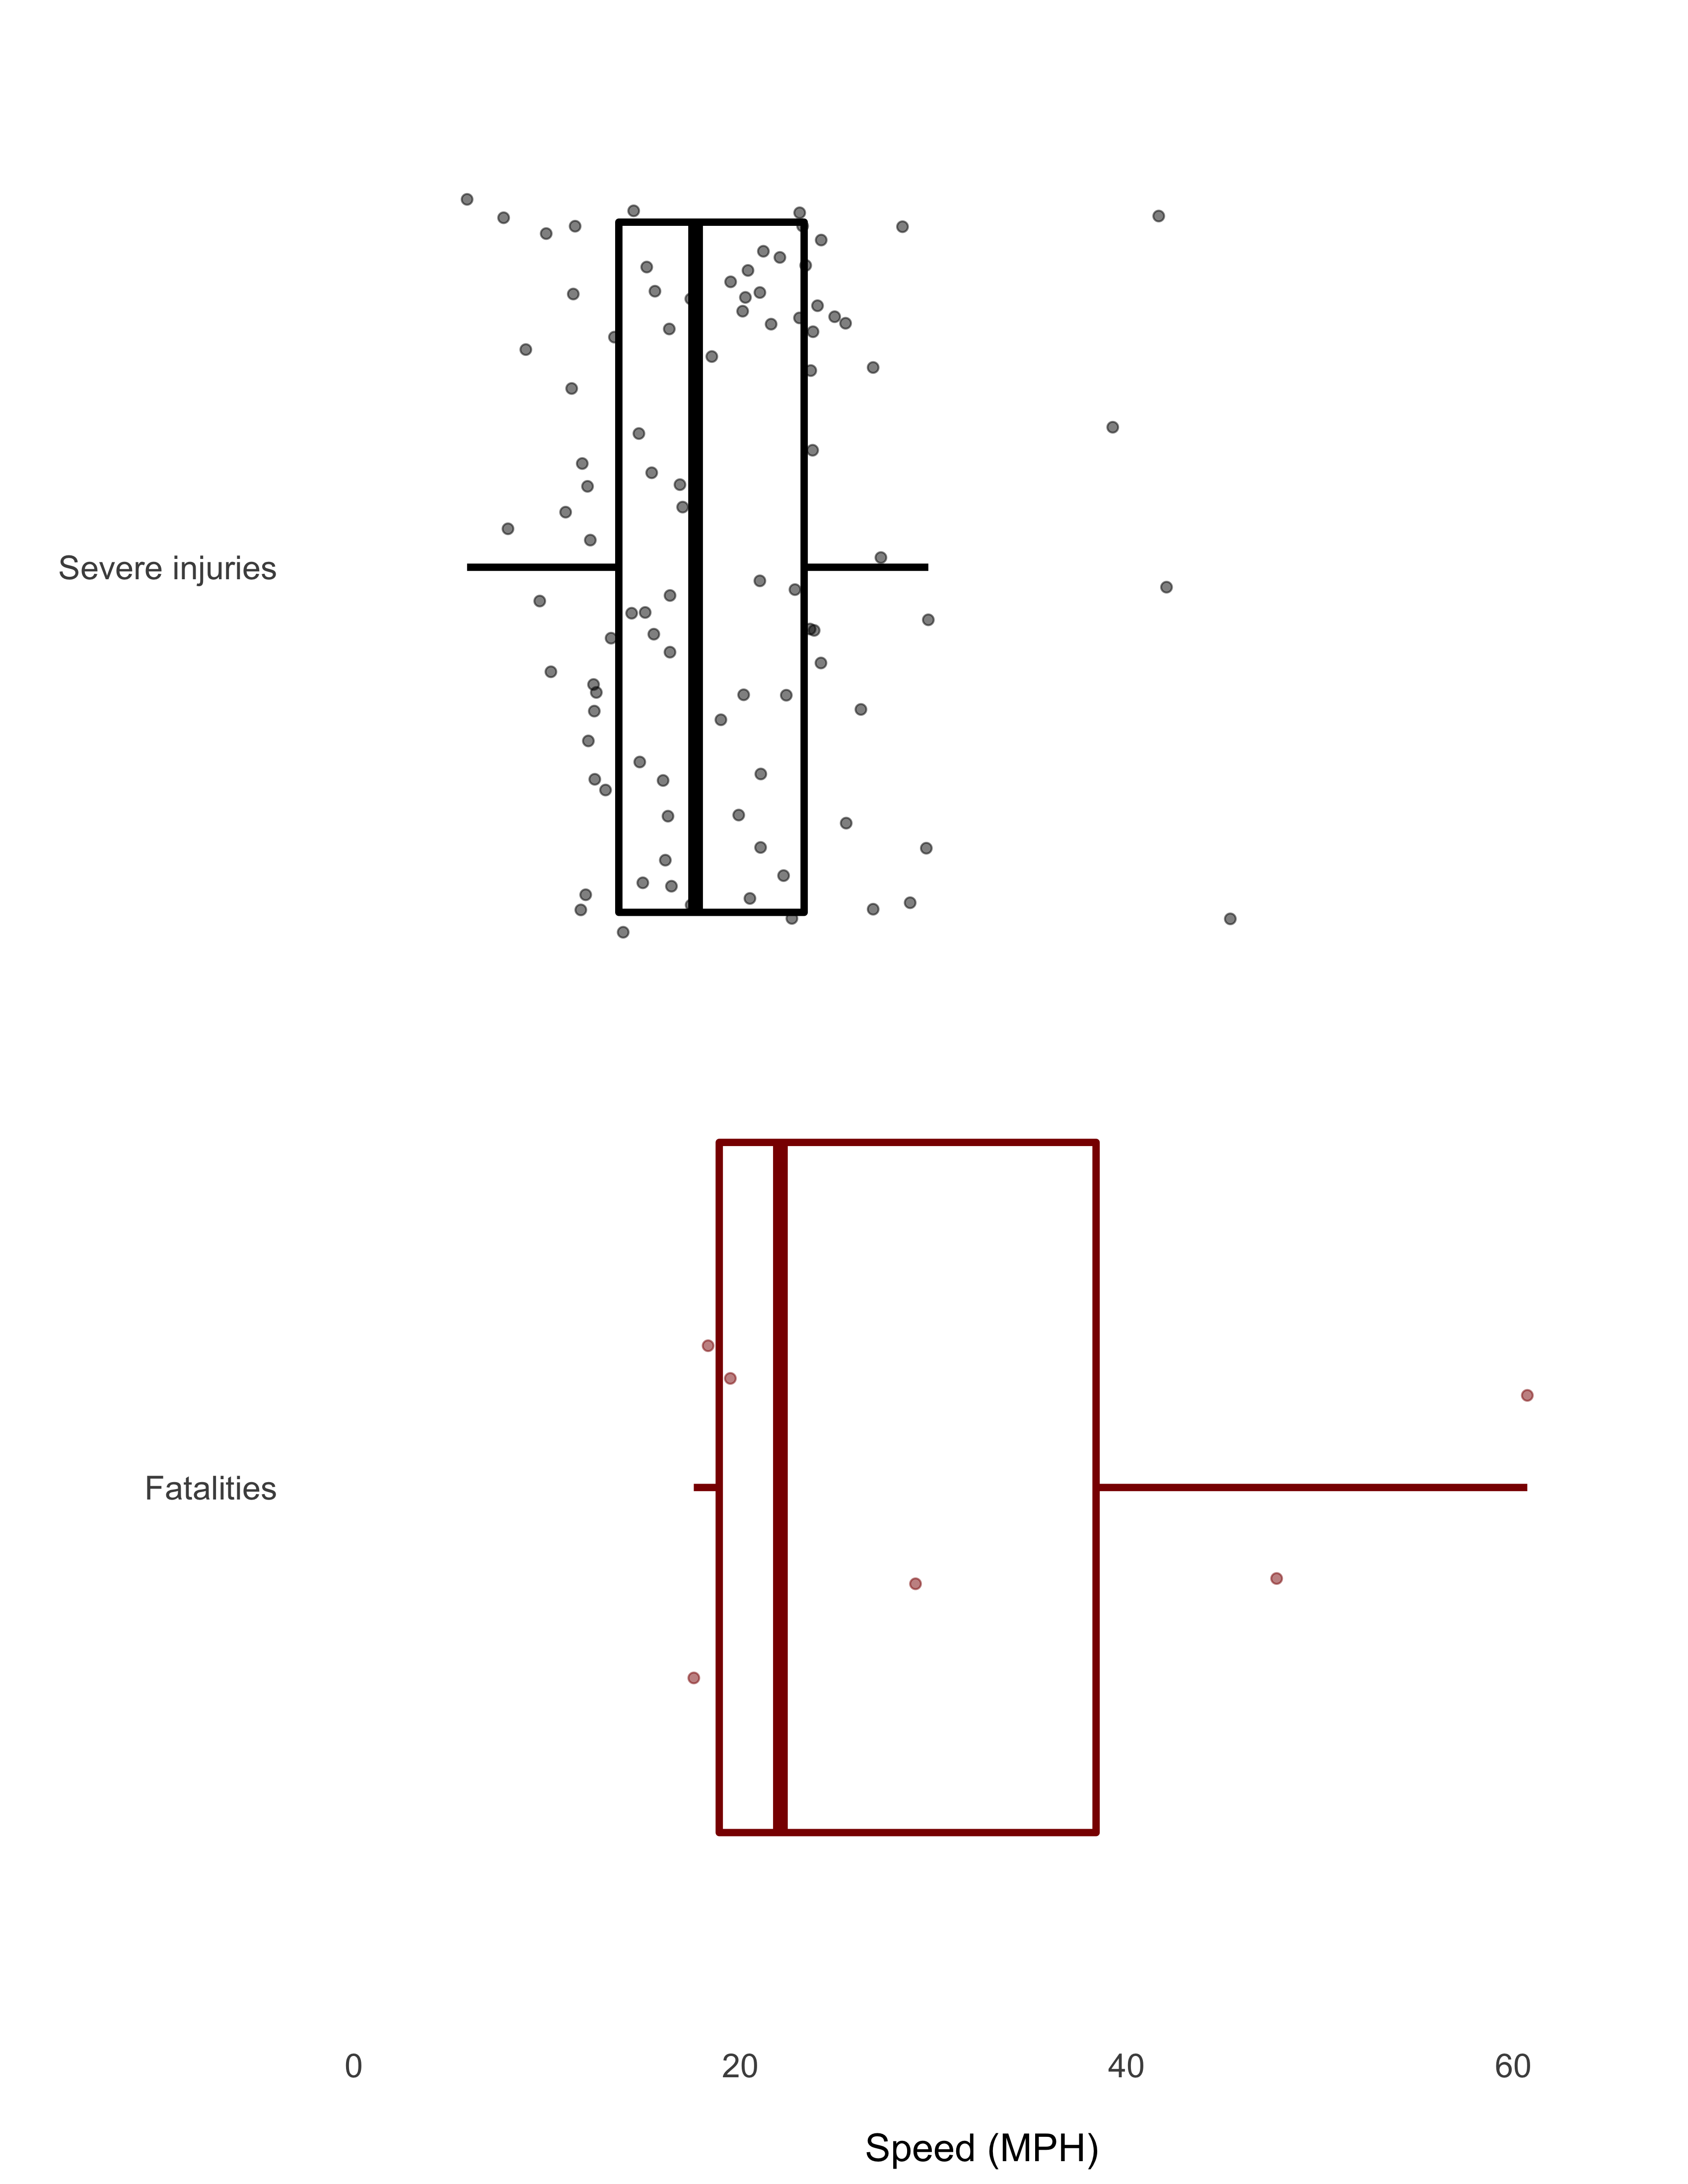

In [39]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot() + 
geom_boxplot(aes(x = VDOI, y = SPEEDS, group = VDOI, color = VDOI), data = cvs, 
             size = 1.25, outlier.shape = NA) +
geom_point(aes(x = VDOI, y = SPEEDS, group = VDOI, color = VDOI), data = cvs, 
           position = "jitter", alpha = 0.5) +
scale_color_manual(values = c("dark red", "black")) +

scale_y_continuous(limits = c(0, 65), breaks = seq(0, 65, by = 20)) + 

theme(text = element_text(size = 14),
      axis.text.x = element_text(size = 12),
      axis.text.y = element_text(size = 12),
      legend.position = "none",
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_blank(),
      axis.ticks.x = element_blank(),
      axis.ticks.y = element_blank()) +

xlab("") +
ylab("\nSpeed (MPH)") + 

coord_flip()

## Fig 3: Scatterplot of age vs. speed by victim degree of injury (VDOI)

In [24]:
# drop the nonsensical/placeholder ages 
cvs_age = cvs.loc[cvs.VICTIM_AGE < 150]

In [25]:
%R -i cvs_age

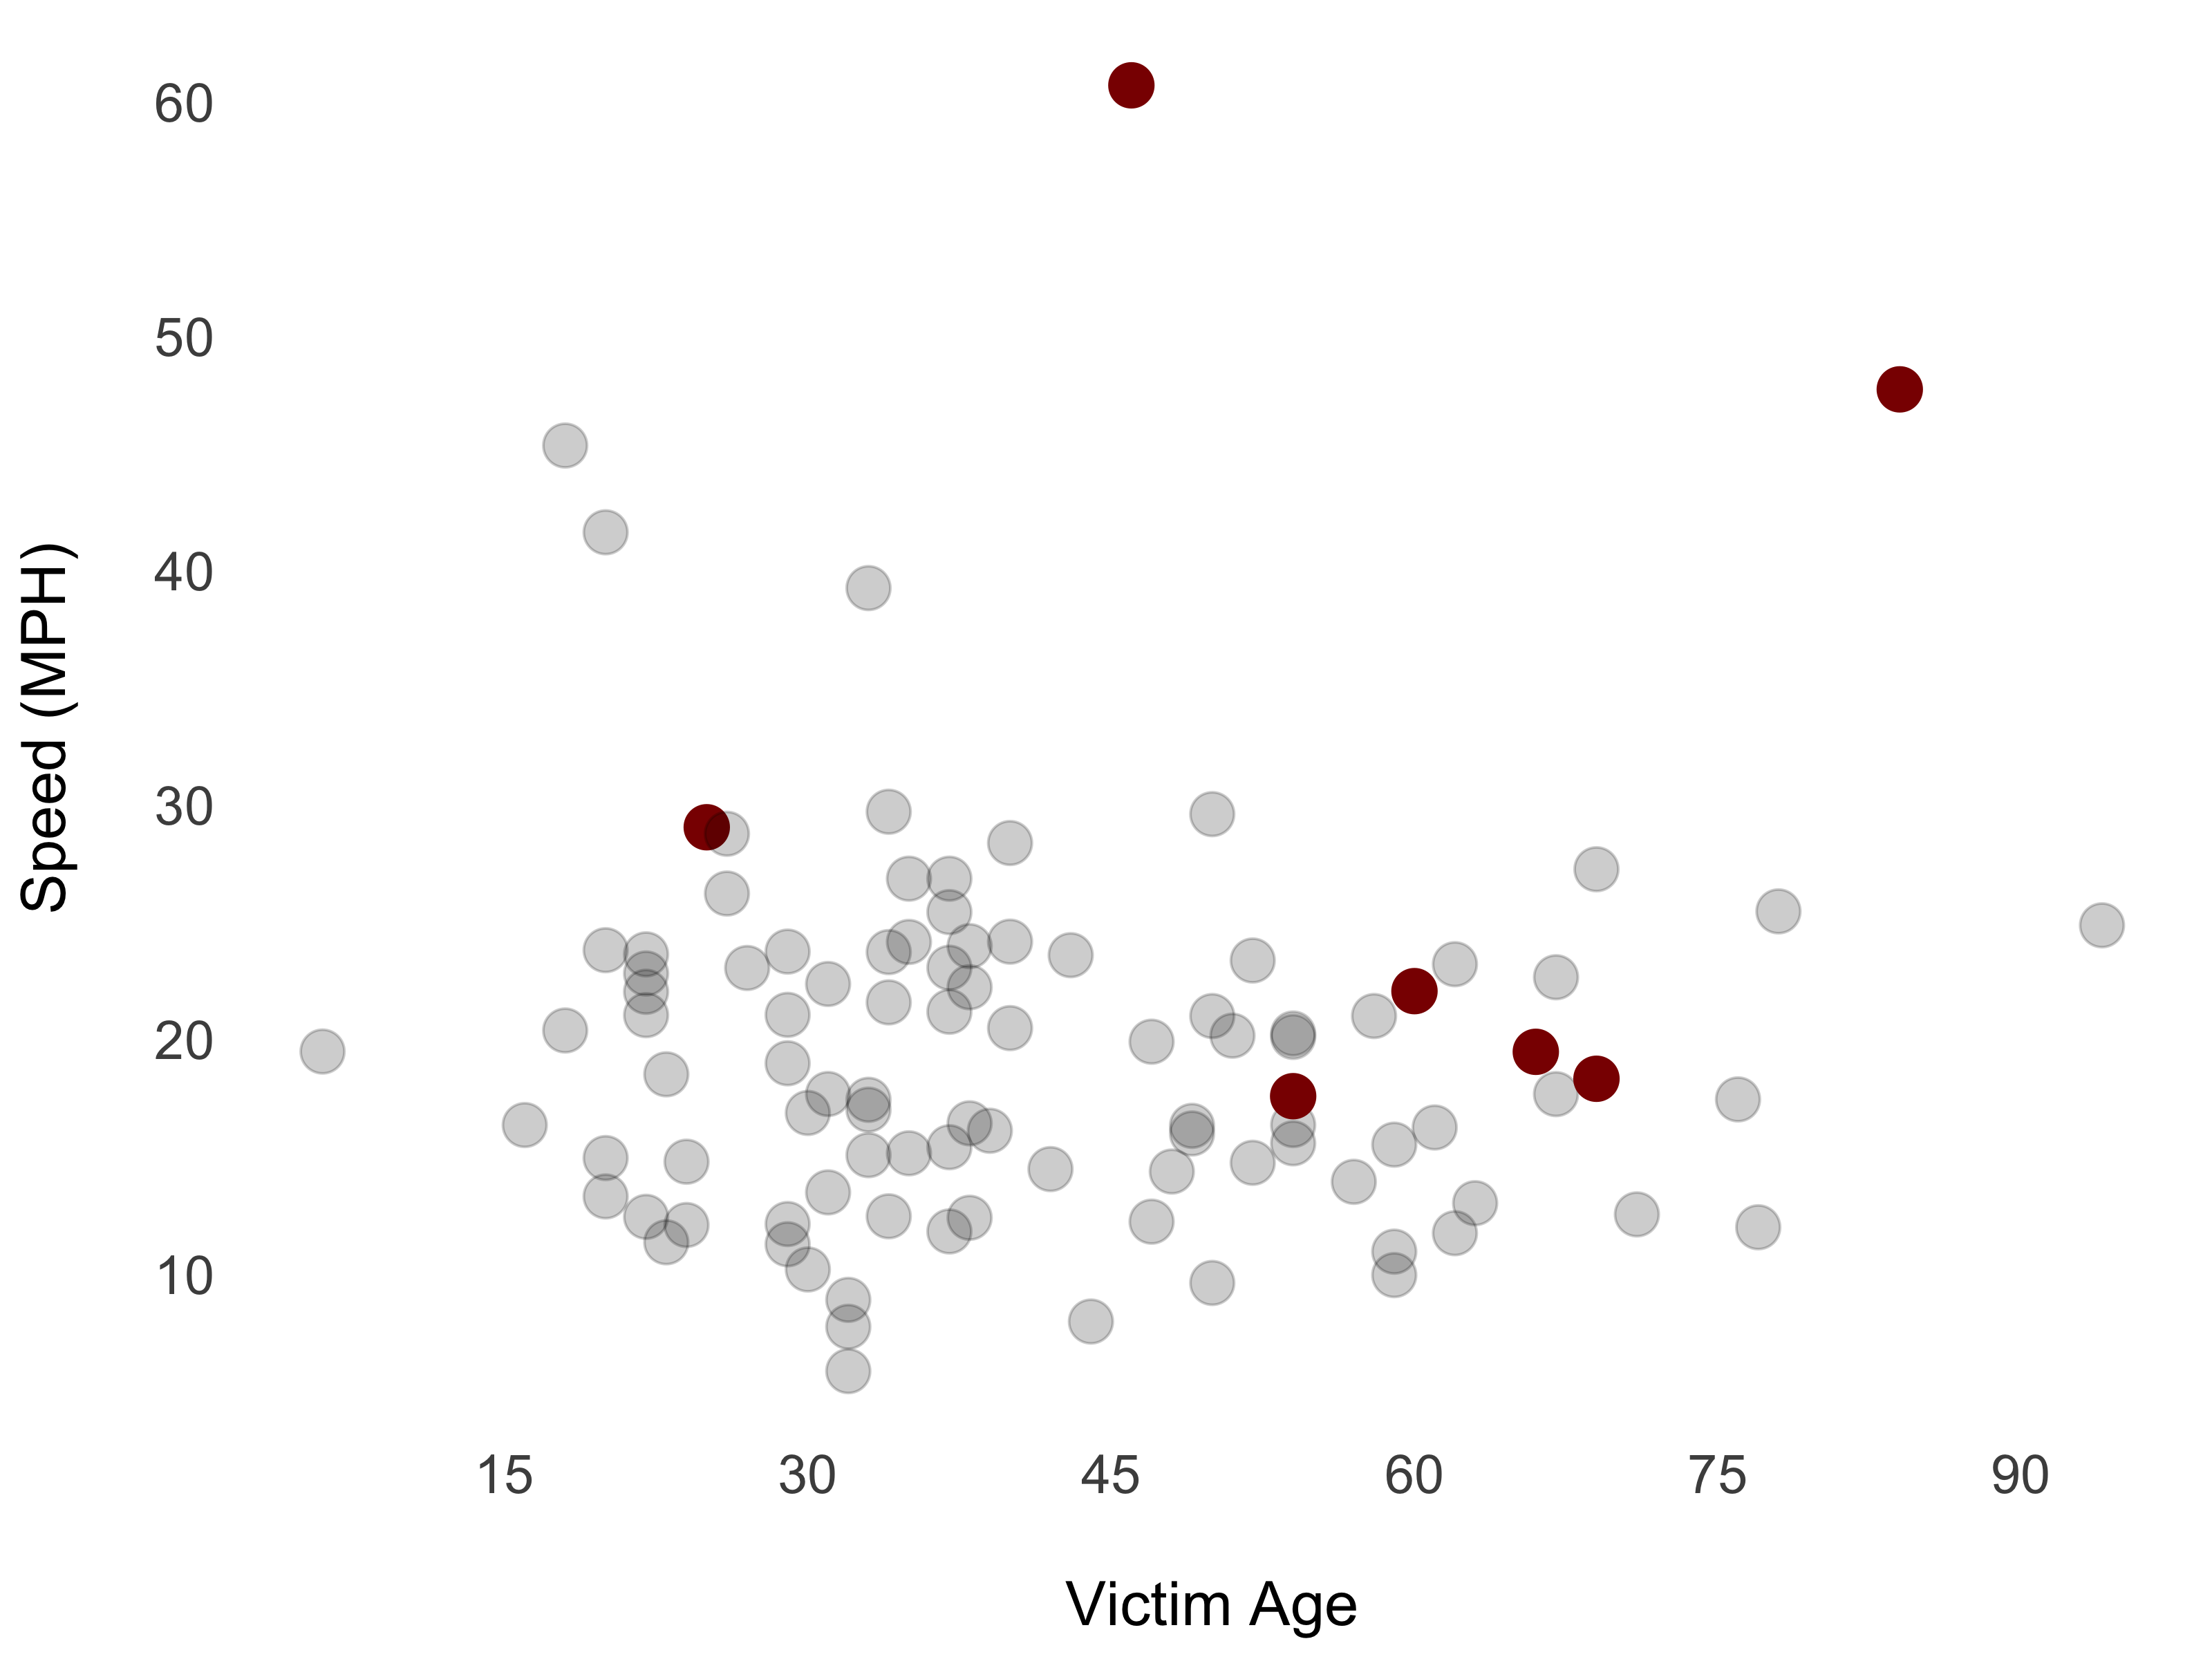

In [26]:
%%R -w 8 -h 6 --units in -r 400

ggplot() +
geom_point(aes(x = VICTIM_AGE, y = SPEEDS, color = VDOI, alpha = VDOI), data = cvs_age, size = 5) +
scale_alpha_discrete(range = c(1, 0.2)) + 
scale_color_manual(values = c("dark red", "black")) +

scale_x_continuous(breaks = seq(0, 90, by = 15)) +
scale_y_continuous(breaks = seq(0, 60, by = 10)) +

theme(text = element_text(size = 16),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 14),
      legend.position = "none",
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_blank(),
      axis.ticks.x = element_blank(),
      axis.ticks.y = element_blank()) +

xlab("\nVictim Age") +
ylab("Speed (MPH)\n")

## Fig 4: Bar chart of number of accidents (by victim degree of injury (VDOI)

In [27]:
cvs_parties = cvs[['VDOI', 'PEDESTRIAN_ACCIDENT', 'BICYCLE_ACCIDENT', 
                   'MOTORCYCLE_ACCIDENT', 'TRUCK_ACCIDENT']]
cvs_parties.columns = ['VDOI', 'Pedestrian', 'Bicycle', 
                   'Motorcycle', 'Truck']
cvs_parties = cvs_parties.groupby(["VDOI"]).sum()
cvs_parties

,Pedestrian,Bicycle,Motorcycle,Truck
VDOI,,,,
Fatalities,4.0,1.0,0.0,0.0
Severe injuries,39.0,13.0,18.0,1.0


In [28]:
cvs_parties = cvs_parties.stack().reset_index()

In [29]:
cvs_parties.columns = ["VDOI", "Parties", "Count"]
cvs_parties

,VDOI,Parties,Count
0,Fatalities,Pedestrian,4.0
1,Fatalities,Bicycle,1.0
2,Fatalities,Motorcycle,0.0
3,Fatalities,Truck,0.0
4,Severe injuries,Pedestrian,39.0
5,Severe injuries,Bicycle,13.0
6,Severe injuries,Motorcycle,18.0
7,Severe injuries,Truck,1.0


In [30]:
%R -i cvs_parties

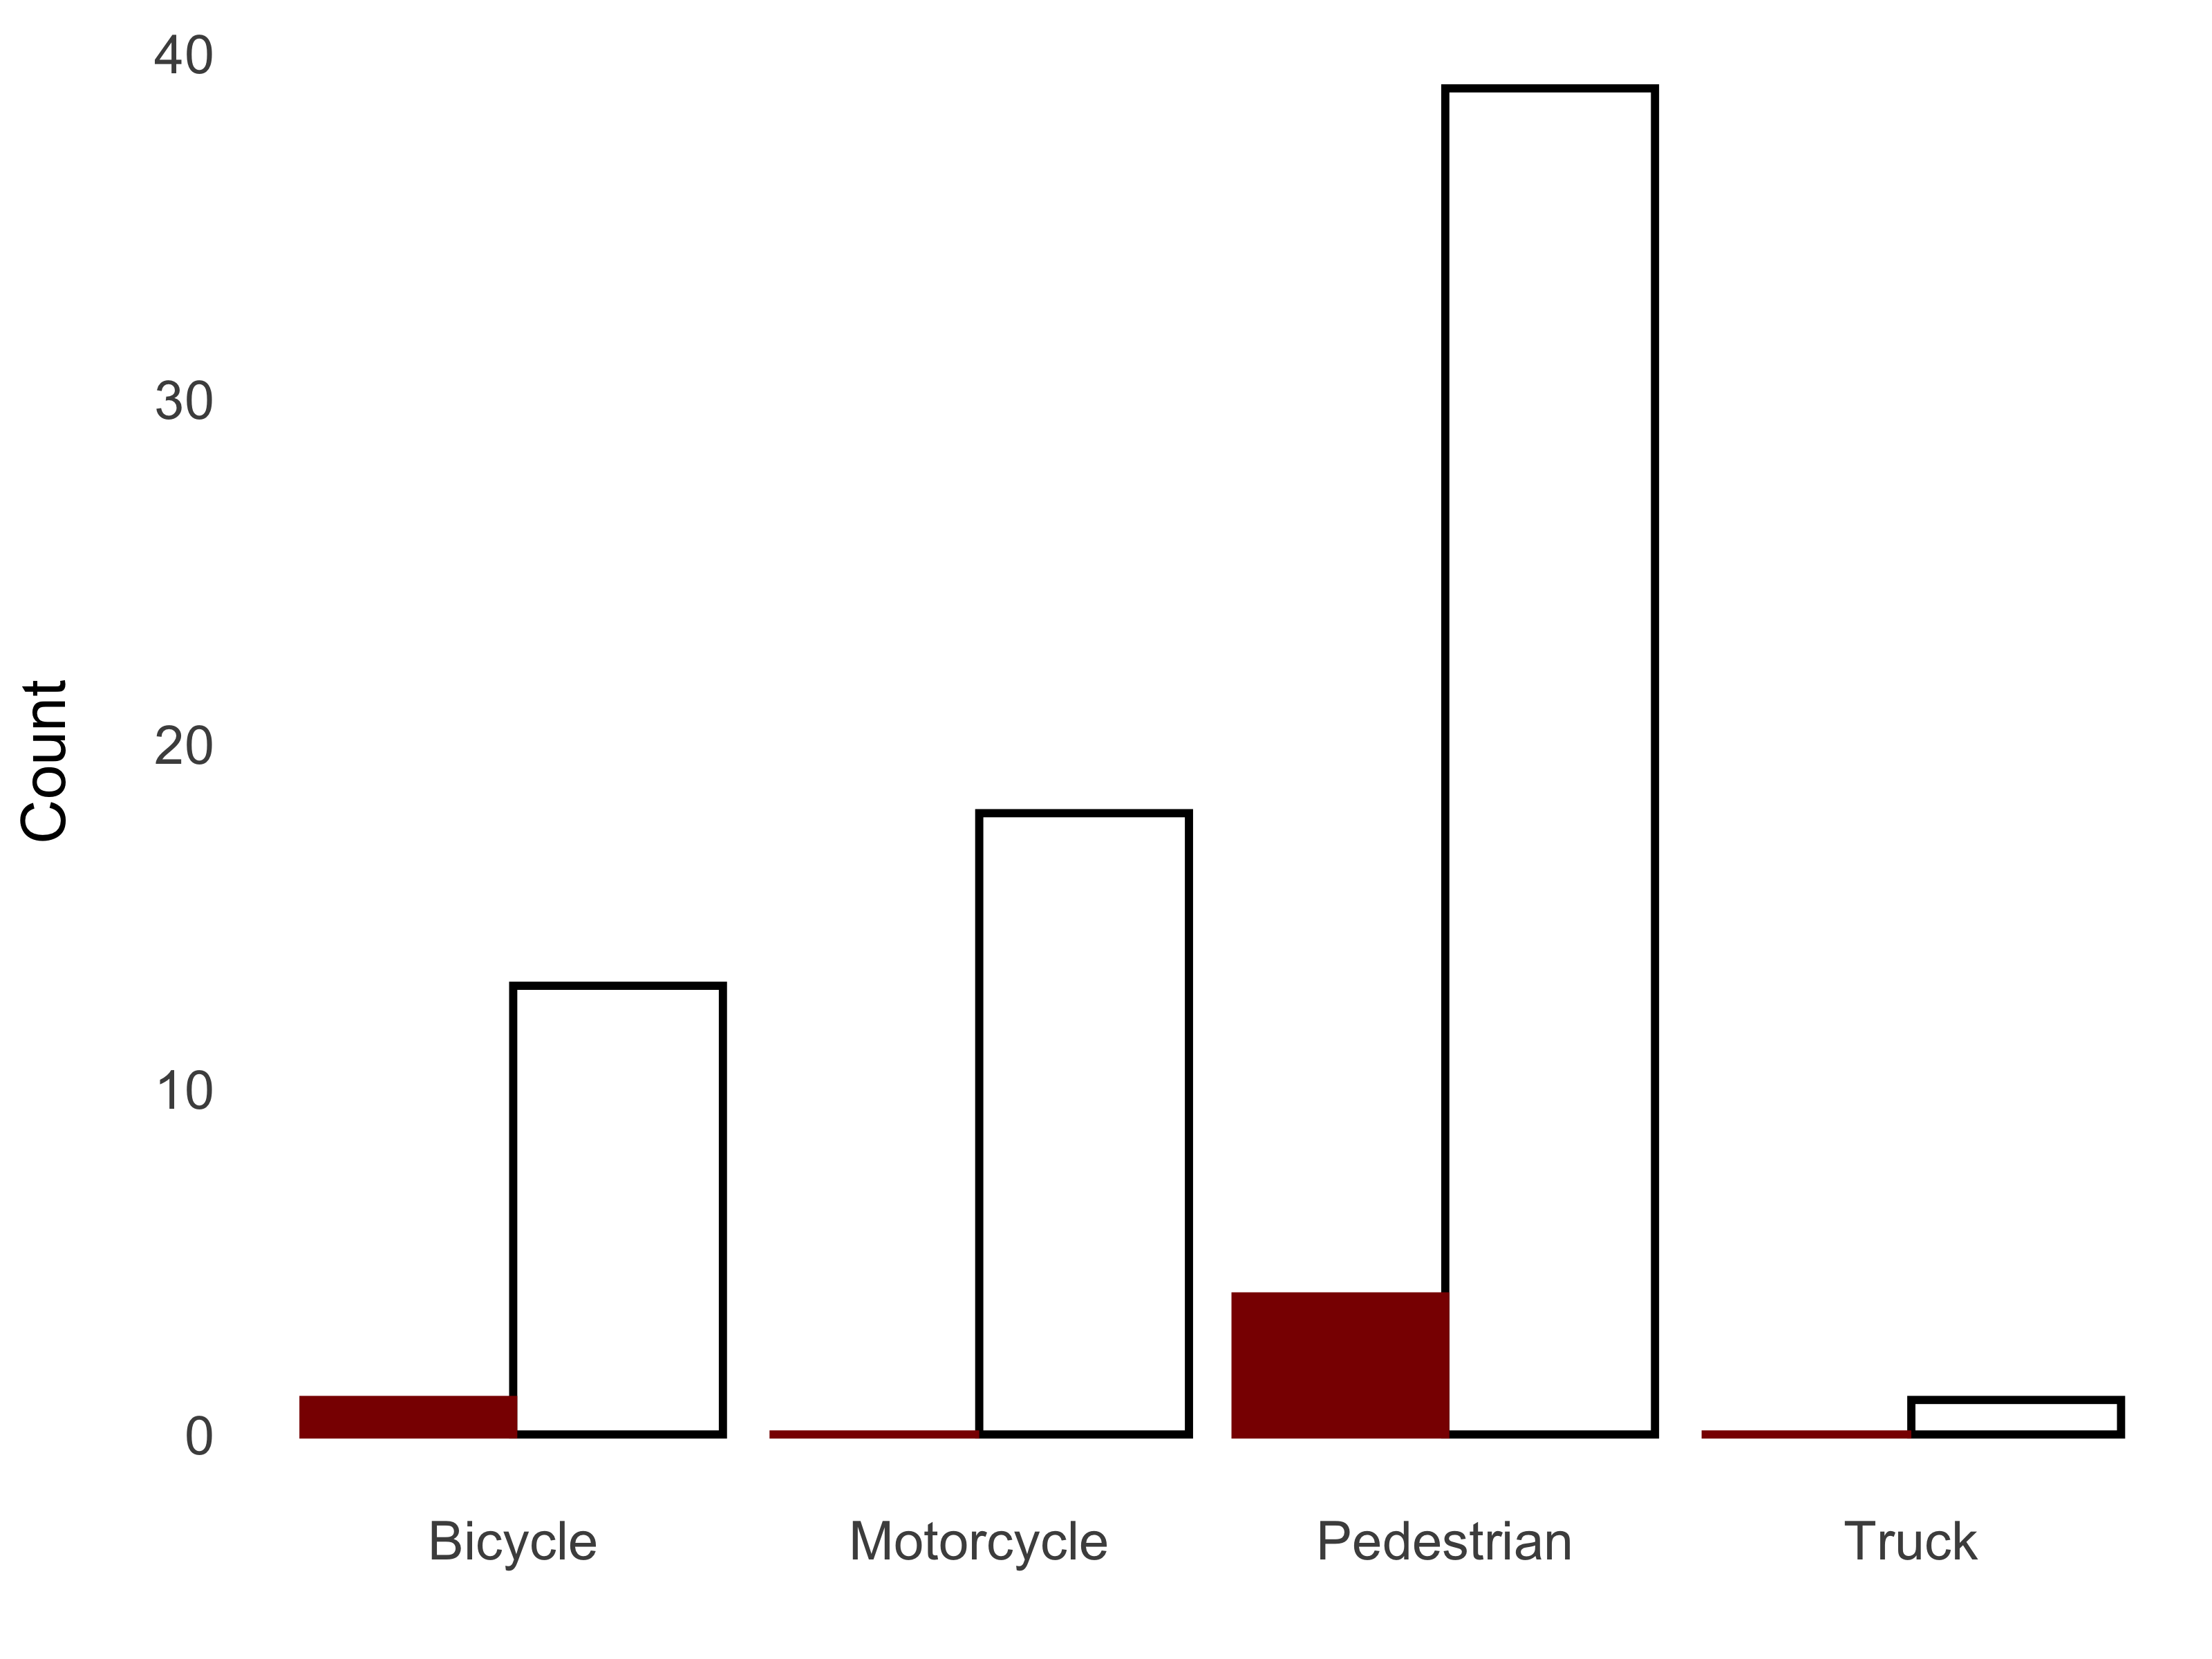

In [31]:
%%R -w 8 -h 6 --units in -r 400 

ggplot() +
geom_bar(aes(x = Parties, y = Count, group = VDOI, color = VDOI, fill = VDOI), data = cvs_parties, 
         stat = "identity", position = position_dodge(), size = 1) + 
scale_color_manual(values = c("dark red", "black")) +
scale_fill_manual(values = c("dark red", "white")) +

scale_y_continuous(breaks = seq(0, 40, by = 10)) +

theme(text = element_text(size = 16),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 14),
      legend.position = "none",
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_blank(),
      axis.ticks.x = element_blank(),
      axis.ticks.y = element_blank()) +

xlab("") + 
ylab("Count\n")

## Fig 5: Heat map of number of accidents by time of day and day of week